# LeNet-300-100: MNIST with TensorFlow 2.8

Trained with _GradientTape()_ API

In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [1]:
import tensorflow
from tensorflow import keras
import tensorflow as tf

# from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
# from tensorflow.keras.initializers import RandomNormal

# import tensorflow.keras.backend as K
# from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import math
import pickle

# from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"number of GPUs available = {num_gpus}")

# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 0
No GPU found


### MNIST Data Pre-processing

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

In [5]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [11]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [12]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [13]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000, 10)
X_test.shape: (10000, 784), y_test.shape: (10000, 10)


In [14]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(60000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(10000).batch(batch_size = batch_size)

### Define LeNet-300-100 architecture

In [15]:
class LeNet300(Model):
    def __init__(self):
        super(LeNet300, self).__init__()
        
        self.dense1 = Dense(
            units = 300, activation = None,
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            use_bias = True, bias_initializer = 'ones'
        )
        self.dense2 = Dense(
            units = 100, activation = None,
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            use_bias = True, bias_initializer = 'ones'
        )
        self.output_layer = Dense(
            units = 10, activation = None,
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            use_bias = True, bias_initializer = 'ones'
        )
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense1(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.softmax(self.output_layer(x))
        return x
        
 

In [16]:
# Initialize and build an instance of LeNet-300-100 dense neural network-
model = LeNet300()
model.build(input_shape = (None, 784))

In [17]:
# Get model summary-
model.summary()

Model: "le_net300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  235500    
                                                                 
 dense_1 (Dense)             multiple                  30100     
                                                                 
 dense_2 (Dense)             multiple                  1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Count number of trainable parameters in a layer-wise manner-
tot_params = 0
for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer.shape: {layer.shape} has {loc_params} params")
    tot_params += loc_params

layer.shape: (784, 300) has 235200 params
layer.shape: (300,) has 300 params
layer.shape: (300, 100) has 30000 params
layer.shape: (100,) has 100 params
layer.shape: (100, 10) has 1000 params
layer.shape: (10,) has 10 params


In [19]:
print(f"LeNet-300-100 has {tot_params} trainable parameters")

LeNet-300-100 has 266610 trainable parameters


In [20]:
# Save random weights-
model.save_weights("LeNet300_Random_Weights.h5", overwrite = True)

In [21]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [22]:
# Choose gradient descent optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0012)

In [23]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

### Train neural network using _tf.GradientTape()_ API

For a detailed code example pertaining to TF2's _learning rate_ schedulers, refere [here](https://github.com/arjun-majumdar/CNN_Classifications/blob/master/LeNet_300_100-Learning_Rate_Decays_and_Scheduler.ipynb)

In [24]:
@tf.function
def train_one_step(model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
            
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list

    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None


In [25]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [26]:
print(f"LeNet-300-100 will be trained for {num_epochs} epochs")

LeNet-300-100 will be trained for 100 epochs


In [27]:
# Python3 dict to contain training metrics-
training_history = {}

In [28]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

best_val_loss = 100
loc_patience = 0

In [29]:
# Train model using 'GradientTape'-    
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
        
        
    for x, y in train_dataset:
        train_one_step(model, optimizer, x, y)

    for x_t, y_t in test_dataset:
        test_step(model, optimizer, x_t, y_t)
    
    
    print(f"Epoch = {epoch + 1}; loss = {train_loss.result():.4f}, "
          f" val loss = {test_loss.result():.4f}, accuracy = {train_accuracy.result() * 100:.2f}%"
          f", val accuracy = {test_accuracy.result() * 100:.2f}%, LR = {optimizer._decayed_lr('float32').numpy():.4f}"
          f" & iterations = {optimizer.iterations.numpy()}"
         )

    training_history[epoch + 1] = {
        'loss': train_loss.result().numpy(), 'val_loss': test_loss.result().numpy(),
        'acc': train_accuracy.result().numpy() * 100, 'val_acc': test_accuracy.result().numpy() * 100,
        'lr': optimizer._decayed_lr('float32').numpy(), 'iterations': optimizer.iterations.numpy()
    }                     
    
    
    # Code for manual Early Stopping:
    if (test_loss.result() < best_val_loss) and (np.abs(test_loss.result() - best_val_loss) >= minimum_delta):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"Saving model with lowest val_loss = {test_loss.result():.4f}\n")
        model.save_weights("LeNet300_best_val_loss.h5", overwrite = True)
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement

        

Epoch = 1; loss = 0.2776,  val loss = 0.1487, accuracy = 91.73%, val accuracy = 95.57%, LR = 0.0012 & iterations = 938
Saving model with lowest val_loss = 0.1487

Epoch = 2; loss = 0.1127,  val loss = 0.0918, accuracy = 96.51%, val accuracy = 97.18%, LR = 0.0012 & iterations = 1876
Saving model with lowest val_loss = 0.0918

Epoch = 3; loss = 0.0740,  val loss = 0.0900, accuracy = 97.65%, val accuracy = 97.39%, LR = 0.0012 & iterations = 2814
Saving model with lowest val_loss = 0.0900

Epoch = 4; loss = 0.0539,  val loss = 0.0690, accuracy = 98.22%, val accuracy = 97.73%, LR = 0.0012 & iterations = 3752
Saving model with lowest val_loss = 0.0690

Epoch = 5; loss = 0.0420,  val loss = 0.0756, accuracy = 98.63%, val accuracy = 97.64%, LR = 0.0012 & iterations = 4690
Epoch = 6; loss = 0.0339,  val loss = 0.0819, accuracy = 98.85%, val accuracy = 97.69%, LR = 0.0012 & iterations = 5628
Epoch = 7; loss = 0.0272,  val loss = 0.0775, accuracy = 99.08%, val accuracy = 97.82%, LR = 0.0012 & ite

In [31]:
# Save training metrics-
with open("LeNet300-training_metrics.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [ ]:
# Load save metrics-
'''
with open("LeNet300-training_metrics.pkl", "rb") as file:
    t_h = pickle.load(file)
'''

In [ ]:
# Sanity check-
# t_h.keys()

In [ ]:
# Sanity check-
# t_h[2].keys()

### Training Visualizations

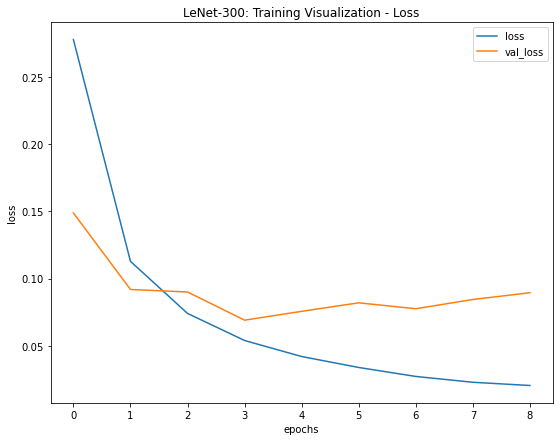

In [38]:
plt.figure(figsize = (9, 7))
plt.plot([training_history[x]['loss'] for x in training_history.keys()], label = 'loss')
plt.plot([training_history[x]['val_loss'] for x in training_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-300: Training Visualization - Loss")
plt.show()

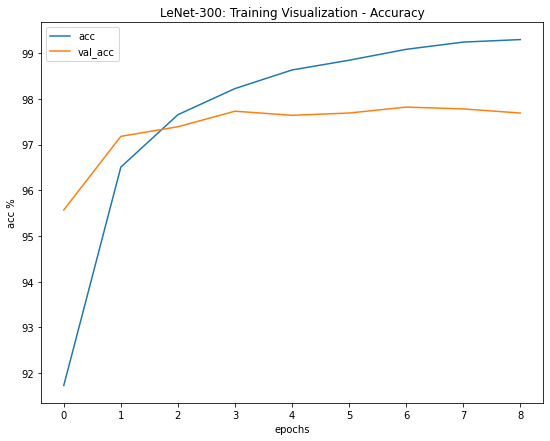

In [40]:
plt.figure(figsize = (9, 7))
plt.plot([training_history[x]['acc'] for x in training_history.keys()], label = 'acc')
plt.plot([training_history[x]['val_acc'] for x in training_history.keys()], label = 'val_acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.legend(loc = 'best')
plt.title("LeNet-300: Training Visualization - Accuracy")
plt.show()

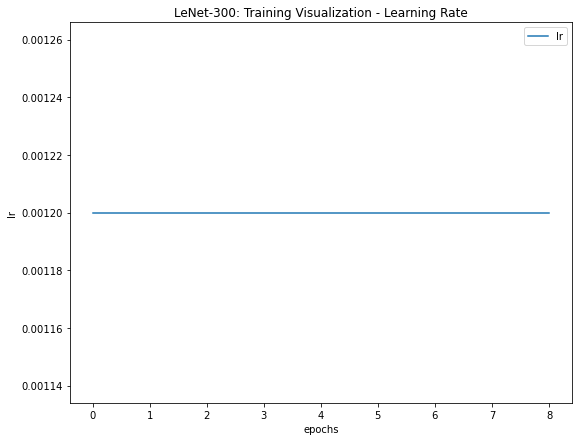

In [41]:
plt.figure(figsize = (9, 7))
plt.plot([training_history[x]['lr'] for x in training_history.keys()], label = 'lr')
plt.xlabel("epochs")
plt.ylabel("lr")
plt.legend(loc = 'best')
plt.title("LeNet-300: Training Visualization - Learning Rate")
plt.show()

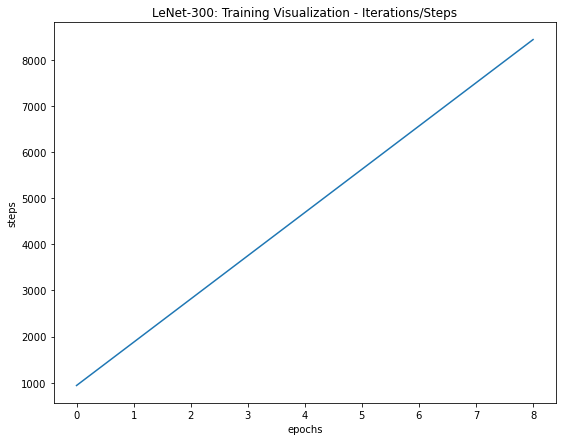

In [43]:
plt.figure(figsize = (9, 7))
plt.plot([training_history[x]['iterations'] for x in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("steps")
# plt.legend(loc = 'best')
plt.title("LeNet-300: Training Visualization - Iterations/Steps")
plt.show()

In [50]:
# Sanity check-
best_model = LeNet300()
best_model.build(input_shape = (None, 784))

In [51]:
# Load pre-trained weights
best_model.load_weights("LeNet300_best_val_loss.h5")

In [52]:
# Compile model-
best_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0012),
    metrics = ['accuracy']
)

In [53]:
# Get evaluation metrics for pre-trained model-
val_loss, val_acc = best_model.evaluate(X_test, y_test, verbose = 1)

313/313 [==============================] - 2s 4ms/step - loss: 0.0694 - accuracy: 0.9773


In [54]:
print(f"LeNet-300-100 validation metrics: loss = {val_loss:.3f} & accuracy = {val_acc * 100:.2f}%")

LeNet-300-100 validation metrics: loss = 0.069 & accuracy = 97.73%


In [55]:
del best_model, val_loss, val_acc